# Projet de MAP568

Elèves :

Alexandre Labrogere

Hugo Artigas

#### Question 1 : Résolution du système

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

In [2]:
def convert_float_to_date(P):
    for i,p in enumerate(P):

        P[i] = np.timedelta64(1,'D')*(p-np.datetime64('2020-02-24').astype('int'))+np.datetime64('2020-02-24')
    return P

In [3]:
#Définition des paramètres d'entrée
S0 = 67*10**(6)
lambda2 = 0

def Para_entree() :
    pa = rd.random()*(0.9 - 0.4)+ 0.4
    pih = rd.random()*(0.2 - 0.05)+ 0.05
    piu = rd.random()*(0.04 - 0.01)+ 0.01
    phd = rd.random()*(0.2 - 0.1)+ 0.1
    phu = rd.random()*(0.2 - 0.1)+ 0.1
    pud = rd.random()*(0.4 - 0.2)+ 0.2
    Ni = rd.random()*(12 - 8)+ 8
    Nh = rd.random()*(25 - 15)+ 15
    Nu = rd.random()*(20 - 10)+ 10
    R0 = rd.random()*(3.4 - 2.9)+ 2.9
    mu = rd.random()*(0.08 - 0.01)+ 0.01
    N = rd.random()*(np.datetime64('2020-03-15')-np.datetime64('2020-02-24'))+np.datetime64('2020-02-24')
    t0 = rd.random()*(np.datetime64('2020-02-24')-np.datetime64('2020-01-25'))+np.datetime64('2020-01-25')
    I0moins = rd.random()*(100)+ 1
    lambda1 = rd.random()*(10**(-3)-10**(-4))+10**(-4)
    
    return (pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1)

In [4]:
# Definition des paramètres du système (les Gamma et Tau contrôlent la propagation de l'épidémie)

def Para_systeme(pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1):
    gammaIR = (pa+(1-pa)*(1-pih-piu))/Ni
    gammaIH = (1-pa)*pih/Ni
    gammaIU = (1-pa)*piu/Ni
    gammaHD = phd/Nh
    gammaHU = phu/Nh
    gammaHR = (1-phd-phu)/Nh
    gammaUD = pud/Nu
    gammaUR = (1-pud)/Nu
    tau0 = R0*(lambda1+gammaIR+gammaIH+gammaIU)/S0
    return(gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0)


In [5]:
pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1 = Para_entree()
gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0 = Para_systeme(pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1)

In [6]:
def tau(n):
    return tau0*np.exp(-mu*np.maximum((n-N)/np.timedelta64(1,'D'),0))

Pour tester si la fonction tau affiche bien les bons résultats.

In [7]:
N = rd.random()*(np.datetime64('2020-03-15')-np.datetime64('2020-02-24'))+np.datetime64('2020-02-24')
t0 = rd.random()*(np.datetime64('2020-02-24')-np.datetime64('2020-01-25'))+np.datetime64('2020-01-25')
print(N,t0)

2020-02-26 2020-02-01


In [8]:
def Simulation_epidemie(S0,I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0):
    X = [[0 for i in range(10)]] #X représente l'ensemble des vecteurs qui regroupent les 10 compartiments du modèle épidémique

    #On initialise notre modèle
    X[0][0] = S0 
    X[0][1] = I0moins

    #On utilise une première approche approximée à l'ordre 1 pour résoudre le système d'équation différentielle
    periode = np.arange(t0, '2020-08-01', dtype='datetime64[D]')
    for n in periode[:-1]:     
        Xnew = [0 for i in range(10)]
        Xold = X[-1]
        Xnew[0] = Xold[0] - tau(n)*Xold[0]*Xold[1]
        Xnew[1] = (1-lambda1)*Xold[1] + tau(n)*Xold[0]*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[1]
        Xnew[2] = Xold[2] + lambda1*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[2]
        Xnew[3] = (1-lambda2)*Xold[3] + gammaIR*Xold[1]
        Xnew[4] = Xold[4] + gammaIR*Xold[2] +lambda2*Xold[3]
        Xnew[5] = (1-(gammaHR+gammaHD+gammaHU))*Xold[5] + gammaIH*(Xold[1]+Xold[2])
        Xnew[6] = (1-(gammaUR+gammaUD))*Xold[6] + gammaIU*(Xold[1]+Xold[2]) + gammaHU*Xold[5]
        Xnew[7] = Xold[7] + gammaHR*Xold[5] + gammaUR*Xold[6]
        Xnew[8] = Xold[8] + gammaUD*Xold[6] + gammaHD*Xold[5]
        Xnew[9] = (lambda1+gammaIH+gammaIU)*Xold[1]
        X.append(Xnew)
    return X,periode

In [9]:
#On obtient donc tous les compartiments du modèle SEIR pour la période étudiée.
def Compartiments_epidemie(X):
    S = np.array([x[0] for x in X[:]])
    Imoins = np.array([x[1] for x in X[:]])
    Iplus = np.array([x[2] for x in X[:]])
    Rmoins = np.array([x[3] for x in X[:]])
    RplusI = np.array([x[4] for x in X[:]])
    H = np.array([x[5] for x in X[:]])
    U = np.array([x[6] for x in X[:]])
    RplusH = np.array([x[7] for x in X[:]])
    D = np.array([x[8] for x in X[:]])
    DR = np.array([x[9] for x in X[:]])
    return S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR

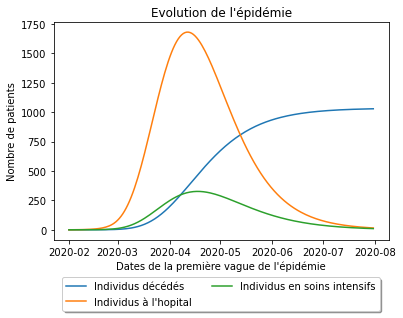

In [10]:
#Simulation épidemie
X,periode = Simulation_epidemie(S0,I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0)
S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie(X)

#Représentation de la vague épidémique
plt.plot(periode,D,label="Individus décédés")
plt.plot(periode,H,label="Individus à l'hopital")
plt.plot(periode,U,label="Individus en soins intensifs")
plt.xlabel("Dates de la première vague de l'épidémie")
plt.ylabel("Nombre de patients")
plt.title("Evolution de l'épidémie")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fancybox=True, shadow=True)

In [43]:
#Post-traitement pic de l'épidémie
Umax = int(np.max(U))
DateUmax = periode[np.argmax(U)]
print("Date critique de l'épidémie : " +str(DateUmax)+" , avec "+str(Umax)+" patients en soins intensifs")

IndexError: index 68116 is out of bounds for axis 0 with size 54

#### Question 2 : loi du pic de l'épidémie par Monte-Carlo

19313.50582306604
[26.761245179666574 56826.93855650074]


(array([4.28861200e-03, 1.88640974e-03, 1.26340191e-03, 9.24369748e-04,
        7.41813967e-04, 6.92552883e-04, 5.67951318e-04, 5.38974210e-04,
        4.57838308e-04, 4.02781802e-04, 3.94088670e-04, 3.44827586e-04,
        2.37612286e-04, 2.95566502e-04, 2.89771081e-04, 2.05737467e-04,
        1.85453492e-04, 2.40509997e-04, 1.99942046e-04, 1.97044335e-04,
        1.68067227e-04, 1.82555781e-04, 1.76760359e-04, 1.56476384e-04,
        1.56476384e-04, 1.30396986e-04, 1.21703854e-04, 1.53578673e-04,
        1.21703854e-04, 1.70964938e-04, 1.15908432e-04, 1.59374094e-04,
        8.98290351e-05, 1.13010722e-04, 7.82381918e-05, 9.56244567e-05,
        9.56244567e-05, 7.24427702e-05, 1.30396986e-04, 9.56244567e-05,
        7.53404810e-05, 8.11359026e-05, 1.10113011e-04, 6.08519270e-05,
        7.53404810e-05, 7.53404810e-05, 6.95450594e-05, 6.95450594e-05,
        5.79542162e-05, 7.53404810e-05, 7.53404810e-05, 9.27267459e-05,
        7.53404810e-05, 6.08519270e-05, 8.69313243e-05, 4.346566

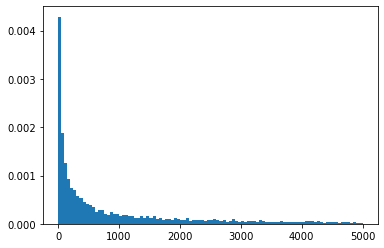

In [12]:
N=10000 #Taille de l'échantillon
U_MC=[]
for i in range(N):
    pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1 = Para_entree()
    gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0 = Para_systeme(pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1)
    X,periode = Simulation_epidemie(S0,I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0)
    S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie(X)
    U_MC.append((np.max(U),periode[np.argmax(U)]))
Pic_MC=np.array(U_MC)

#Loi du nombre maximal de patients en soins intensifs

print(np.nanmean(Pic_MC[:,0]))
print(np.quantile(Pic_MC[:,0], [0.1, 0.9]))
plt.hist(Pic_MC[:,0],bins=100,density=1,range=[0,5000])




In [13]:
print("La loi de la valeur maximale de l'épidémie suit une loi exponentielle d'espérance " + str(np.mean(Pic_MC[:,0])))

La loi de la valeur maximale de l'épidémie suit une loi exponentielle d'espérance 19313.50582306604


(array([ 10.,  38.,  94., 289., 284., 354., 459., 779., 562., 620., 925.,
        586., 512., 416., 555., 334., 285., 421., 242., 202., 193., 221.,
        166., 138., 139., 205., 116.,  98., 127.,  78.,  71.,  53.,  70.,
         47.,  52.,  59.,  35.,  30.,  23.,  24.,  25.,  14.,  21.,   9.,
          4.,   4.,   4.,   5.,   1.,   1.]),
 array([18341.  , 18343.28, 18345.56, 18347.84, 18350.12, 18352.4 ,
        18354.68, 18356.96, 18359.24, 18361.52, 18363.8 , 18366.08,
        18368.36, 18370.64, 18372.92, 18375.2 , 18377.48, 18379.76,
        18382.04, 18384.32, 18386.6 , 18388.88, 18391.16, 18393.44,
        18395.72, 18398.  , 18400.28, 18402.56, 18404.84, 18407.12,
        18409.4 , 18411.68, 18413.96, 18416.24, 18418.52, 18420.8 ,
        18423.08, 18425.36, 18427.64, 18429.92, 18432.2 , 18434.48,
        18436.76, 18439.04, 18441.32, 18443.6 , 18445.88, 18448.16,
        18450.44, 18452.72, 18455.  ]),
 <BarContainer object of 50 artists>)

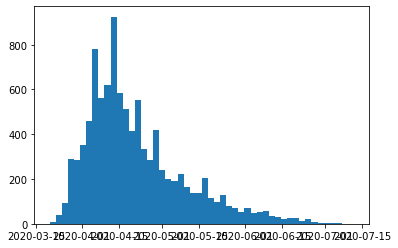

In [14]:
#Loi du jour de la date du pic de l'épidémie
plt.hist(Pic_MC[:,1],bins = 50)

In [15]:
pic = np.zeros_like(Pic_MC[:,1])
for i,d in enumerate(Pic_MC[:,1]):
    pic[i] = d.astype('float')
m = np.mean(pic)
mean_date = np.timedelta64(1,'D')*(m-np.datetime64('2020-02-24').astype('int'))+np.datetime64('2020-02-24')
print("La loi de la date du pic  de l'épidémie suit une loi de poisson d'espérance " + str(mean_date))

La loi de la date du pic  de l'épidémie suit une loi de poisson d'espérance 2020-04-21


#### Question 3: Analyse de la sensisibilité par méthode de Morris

In [16]:
!pip install SALib

In [17]:
import SALib.sample.morris
import SALib.analyze.morris

In [18]:
def Para_systeme_vector(x):
    pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1 = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14]
    gammaIR = (pa+(1-pa)*(1-pih-piu))/Ni
    gammaIH = (1-pa)*pih/Ni
    gammaIU = (1-pa)*piu/Ni
    gammaHD = phd/Nh
    gammaHU = phu/Nh
    gammaHR = (1-phd-phu)/Nh
    gammaUD = pud/Nu
    gammaUR = (1-pud)/Nu
    tau0 = R0*(lambda1+gammaIR+gammaIH+gammaIU)/S0
    return np.array([I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0])

In [19]:
def Simulation_epidemie_vector(x,t0,N):
    X = [[0 for i in range(10)]] #X représente l'ensemble des vecteurs qui regroupent les 10 compartiments du modèle épidémique
    I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0 = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]
    #On initialise notre modèle
    X[0][0] = S0 
    X[0][1] = I0moins

    #On utilise une première approche approximée à l'ordre 1 pour résoudre le système d'équation différentielle
    periode = np.arange(t0, np.datetime64('2020-08-01').astype('int'))
    for n in periode[:-1]:     
        Xnew = [0 for i in range(10)]
        Xold = X[-1]
        Xnew[0] = Xold[0] - tau(n.astype('float'),N)*Xold[0]*Xold[1]
        Xnew[1] = (1-lambda1)*Xold[1] + tau(n.astype('float'),N)*Xold[0]*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[1]
        Xnew[2] = Xold[2] + lambda1*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[2]
        Xnew[3] = (1-lambda2)*Xold[3] + gammaIR*Xold[1]
        Xnew[4] = Xold[4] + gammaIR*Xold[2] +lambda2*Xold[3]
        Xnew[5] = (1-(gammaHR+gammaHD+gammaHU))*Xold[5] + gammaIH*(Xold[1]+Xold[2])
        Xnew[6] = (1-(gammaUR+gammaUD))*Xold[6] + gammaIU*(Xold[1]+Xold[2]) + gammaHU*Xold[5]
        Xnew[7] = Xold[7] + gammaHR*Xold[5] + gammaUR*Xold[6]
        Xnew[8] = Xold[8] + gammaUD*Xold[6] + gammaHD*Xold[5]
        Xnew[9] = (lambda1+gammaIH+gammaIU)*Xold[1]
        X.append(Xnew)
    return X,periode

def Compartiments_epidemie_vector(X):
    S = np.array([x[0] for x in X[:]])
    Imoins = np.array([x[1] for x in X[:]])
    Iplus = np.array([x[2] for x in X[:]])
    Rmoins = np.array([x[3] for x in X[:]])
    RplusI = np.array([x[4] for x in X[:]])
    H = np.array([x[5] for x in X[:]])
    U = np.array([x[6] for x in X[:]])
    RplusH = np.array([x[7] for x in X[:]])
    D = np.array([x[8] for x in X[:]])
    DR = np.array([x[9] for x in X[:]])
    return S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR


In [20]:
def tau(n,N):
    return tau0*np.exp(-mu*np.maximum((n-N),0))

In [21]:
problem = {
    'num_vars':15,
    'names' : ['pa','pih','piu','phd','phu','pud','Ni','Nh','Nu','R0','mu','N','t0','I0moins','lambda1'],
    'bounds' : [[0.4,0.9],[0.05,0.2],[0.01,0.04],[0.1,0.2],[0.1,0.2],[0.2,0.4],[8,12],[15,25],[10,20],[2.9,3.4],[0.01,0.08],[np.datetime64('2020-02-24').astype('int'),np.datetime64('2020-03-15').astype('int')],[np.datetime64('2020-01-25').astype('int'),np.datetime64('2020-02-24').astype('int')],[1,100],[10**(-4),10**(-3)]]
}

def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    for i,X in enumerate(parametres):
        variables = X
        variables[6] = np.round(variables[6])
        variables[8] = np.round(variables[8])
        variables[13] = np.round(variables[13])
        constants = Para_systeme_vector(variables)
        t0 = np.round(variables[12])
        N = np.round(variables[11])
        x,periode = Simulation_epidemie_vector(constants,t0,N)
        S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie_vector(x)
        peak_value[i] = np.max(U)
        peak_day[i] = periode[np.argmax(U)]
    return peak_value,peak_day

In [22]:
X = SALib.sample.morris.sample(problem,100,num_levels=20)
peak_value, peak_day = Resolution(X)

In [23]:
print('Sensibilité par méthode Morris pour la valeur maximale')
Smorris_value  =SALib.analyze.morris.analyze(problem,X,peak_value,conf_level=0.95,print_to_console=True,num_levels=20)
print('Sensibilité par méthode Morris pour la date où on atteint la valeur maximale')
Smorris_day  =SALib.analyze.morris.analyze(problem,X,peak_day,conf_level=0.95,print_to_console=True,num_levels=20)


Sensibilité par méthode Morris pour la valeur maximale
Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
pa                              80826.704 -80826.704       20122.000 111587.103
pih                             25992.973  25992.973        8141.193  38990.661
piu                             50780.307  50780.307       15034.028  70108.790
phd                                 0.000      0.000           0.000      0.000
phu                             11424.408  11424.408        3702.048  18946.856
pud                                 0.000      0.000           0.000      0.000
Ni                              52804.849  52804.849       13110.174  58870.905
Nh                               5081.806  -5081.806        1595.871   7783.930
Nu                              24626.351  24626.351        5961.873  31005.239
R0                                  0.000      0.000           0.000      0.000
mu                                  0.000      0.000           0.

#### Question 4: Analyse de sensibilité par méthode de Sobol

In [24]:
from SALib.sample import saltelli
from SALib.analyze import sobol

X = saltelli.sample(problem,100,calc_second_order=True)
param_values,peak_day = Resolution(X)
print('Sensibilité (Sobol) pour la valeur maximale')
Si_peak_value = sobol.analyze(problem,peak_value,print_to_console=True)
print('Sensibilité (Sobol) pour la date où on atteint la valeur maximale')
Si_peak_value = sobol.analyze(problem,peak_day,print_to_console=True)

Sensibilité (Sobol) pour la valeur maximale
Group S1 S1_conf ST ST_conf
pa 0.045240 0.089817 0.124989 0.111299
pih -0.126294 0.393471 0.473353 0.249725
piu -0.168697 0.403770 0.593007 0.311174
phd -0.139284 0.411527 0.648836 0.329584
phu -0.059634 0.478747 0.831837 0.355187
pud -0.063257 0.523886 1.098065 0.569864
Ni -0.049372 0.557958 1.125897 0.579847
Nh 0.068400 0.598844 1.117558 0.661565
Nu 0.045908 0.541076 0.945203 0.461507
R0 -0.110758 0.430703 0.998555 0.539648
mu -0.083611 0.458574 1.058334 0.509422
N -0.090326 0.468138 1.057529 0.488218
t0 -0.102743 0.490984 1.257970 0.900320
I0moins -0.080552 0.529651 1.440866 0.988141
lambda1 0.044258 0.615805 1.616329 0.948530

Group_1 Group_2 S2 S2_conf
pa pih -0.071749 0.236311
pa piu -0.037139 0.263862
pa phd -0.136523 0.286322
pa phu -0.169765 0.341755
pa pud 0.012742 0.415651
pa Ni 0.125869 0.460610
pa Nh -0.057435 0.384858
pa Nu -0.132574 0.359479
pa R0 0.104498 0.418011
pa mu 0.079573 0.433595
pa N 0.116349 0.403781
pa t0 0.206613 0

S1 désigne les indices du premier ordre et ST désigne les indices totaux.

#### Question  5: Analyse de sensibilité quantitative de : Sobol pour les paramètres dont on a les données

In [25]:
np.datetime64('2020-05-11').astype('int') - np.datetime64('2020-03-18').astype('int')

54

In [26]:
def Simulation_epidemie_data(x,t0,N):
    X = [[0 for i in range(10)]] #X représente l'ensemble des vecteurs qui regroupent les 10 compartiments du modèle épidémique
    I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0 = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]
    #On initialise notre modèle
    X[0][0] = S0 
    X[0][1] = I0moins

    #On utilise une première approche approximée à l'ordre 1 pour résoudre le système d'équation différentielle
    periode = np.arange(t0, np.datetime64('2020-05-11').astype('int'))
    for n in periode[:-1]:     
        Xnew = [0 for i in range(10)]
        Xold = X[-1]
        Xnew[0] = Xold[0] - tau(n.astype('float'),N)*Xold[0]*Xold[1]
        Xnew[1] = (1-lambda1)*Xold[1] + tau(n.astype('float'),N)*Xold[0]*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[1]
        Xnew[2] = Xold[2] + lambda1*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[2]
        Xnew[3] = (1-lambda2)*Xold[3] + gammaIR*Xold[1]
        Xnew[4] = Xold[4] + gammaIR*Xold[2] +lambda2*Xold[3]
        Xnew[5] = (1-(gammaHR+gammaHD+gammaHU))*Xold[5] + gammaIH*(Xold[1]+Xold[2])
        Xnew[6] = (1-(gammaUR+gammaUD))*Xold[6] + gammaIU*(Xold[1]+Xold[2]) + gammaHU*Xold[5]
        Xnew[7] = Xold[7] + gammaHR*Xold[5] + gammaUR*Xold[6]
        Xnew[8] = Xold[8] + gammaUD*Xold[6] + gammaHD*Xold[5]
        Xnew[9] = (lambda1+gammaIH+gammaIU)*Xold[1]
        X.append(Xnew)
    return X[len(X)-54:],periode


def Compartiments_epidemie_list(X):
    S = [x[0] for x in X[:]]
    Imoins = [x[1] for x in X[:]]
    Iplus = [x[2] for x in X[:]]
    Rmoins = [x[3] for x in X[:]]
    RplusI = [x[4] for x in X[:]]
    H = [x[5] for x in X[:]]
    U = [x[6] for x in X[:]]
    RplusH = [x[7] for x in X[:]]
    D = [x[8] for x in X[:]]
    DR = [x[9] for x in X[:]]
    return S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR

In [27]:
def Resolution_bis(parametres):
    Ht= []
    Ut = []
    Dt = []
    Rt = []
    for i,X in enumerate(parametres):
        variables = X
        variables[6] = np.round(variables[6])
        variables[8] = np.round(variables[8])
        variables[13] = np.round(variables[13])
        constants = Para_systeme_vector(variables)
        t0 = np.round(variables[12])
        N = np.round(variables[11])
        x,periode = Simulation_epidemie_data(constants,t0,N)
        S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie_list(x)
        Ht.append(H)
        Ut.append(U)
        Dt.append(D)
        Rt.append(RplusH)
    return Ht, Ut, Dt, Rt

def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    for i,X in enumerate(parametres):
        variables = X
        variables[6] = np.round(variables[6])
        variables[8] = np.round(variables[8])
        variables[13] = np.round(variables[13])
        constants = Para_systeme_vector(variables)
        t0 = np.round(variables[12])
        N = np.round(variables[11])
        x,periode = Simulation_epidemie_vector(constants,t0,N)
        S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie_vector(x)
        peak_value[i] = np.max(U)
        peak_day[i] = periode[np.argmax(U)]
    return peak_value,peak_day

In [28]:
X = saltelli.sample(problem,100)
H, U, D, RplusH = Resolution_bis(X)
H = np.array(H)
U = np.array(U)
D = np.array(D)
RplusH = np.array(RplusH)

In [29]:
periode = np.arange(np.datetime64('2020-03-18'), np.datetime64('2020-05-11'))
periode

array(['2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
       '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
       '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
       '2020-05-09', '2020-05-10'], dtype='datetime64[D]')

In [30]:
pa =[]
pih =[]
piu =[]
phd =[]
phu =[]
pud =[]
Ni =[]
Nh =[]
Nu =[]
R0 =[]
mu =[]
N =[]
t0 =[]
I0moins =[]
lambda1 =[]
pat =[]
piht =[]
piut =[]
phdt =[]
phut =[]
pudt =[]
Nit =[]
Nht =[]
Nut =[]
R0t =[]
mut =[]
Nt =[]
t0t =[]
I0moinst =[]
lambda1t =[]
for i in range(len(H[0])):
    h = H[:,i]
    Si_H = sobol.analyze(problem,h)
    pa.append(Si_H['S1'][0])
    pih.append(Si_H['S1'][1])
    piu.append(Si_H['S1'][2])
    phd.append(Si_H['S1'][3])
    phu.append(Si_H['S1'][4])
    pud.append(Si_H['S1'][5])
    Ni.append(Si_H['S1'][6])
    Nh.append(Si_H['S1'][7])
    Nu.append(Si_H['S1'][8])
    R0.append(Si_H['S1'][9])
    mu.append(Si_H['S1'][10])
    N.append(Si_H['S1'][11])
    t0.append(Si_H['S1'][12])
    I0moins.append(Si_H['S1'][13])
    lambda1.append(Si_H['S1'][14])
    pat.append(Si_H['ST'][0])
    piht.append(Si_H['ST'][1])
    piut.append(Si_H['ST'][2])
    phdt.append(Si_H['ST'][3])
    phut.append(Si_H['ST'][4])
    pudt.append(Si_H['ST'][5])
    Nit.append(Si_H['ST'][6])
    Nht.append(Si_H['ST'][7])
    Nut.append(Si_H['ST'][8])
    R0t.append(Si_H['ST'][9])
    mut.append(Si_H['ST'][10])
    Nt.append(Si_H['ST'][11])
    t0t.append(Si_H['ST'][12])
    I0moinst.append(Si_H['ST'][13])
    lambda1t.append(Si_H['ST'][14])



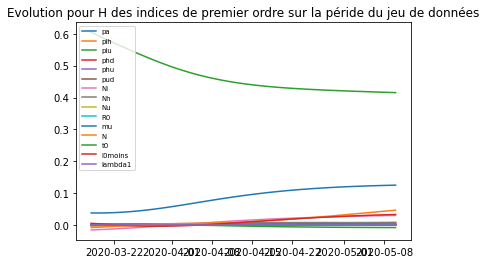

In [44]:
plt.plot(periode,pa,label='pa')
plt.plot(periode,pih,label='pih')
plt.plot(periode,piu,label='piu')
plt.plot(periode,phd,label='phd')
plt.plot(periode,phu,label='phu')
plt.plot(periode,pud,label='pud')
plt.plot(periode,Ni,label='Ni')
plt.plot(periode,Nh,label='Nh')
plt.plot(periode,Nu,label='Nu')
plt.plot(periode,R0,label='R0')
plt.plot(periode,mu,label='mu')
plt.plot(periode,N,label='N')
plt.plot(periode,t0,label='t0')
plt.plot(periode,I0moins,label='I0moins')
plt.plot(periode,lambda1,label='lambda1')
plt.title('Evolution pour H des indices de premier ordre sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

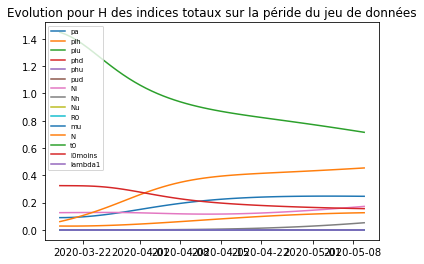

In [32]:
plt.plot(periode,pat,label='pa')
plt.plot(periode,piht,label='pih')
plt.plot(periode,piut,label='piu')
plt.plot(periode,phdt,label='phd')
plt.plot(periode,phut,label='phu')
plt.plot(periode,pudt,label='pud')
plt.plot(periode,Nit,label='Ni')
plt.plot(periode,Nht,label='Nh')
plt.plot(periode,Nut,label='Nu')
plt.plot(periode,R0t,label='R0')
plt.plot(periode,mut,label='mu')
plt.plot(periode,Nt,label='N')
plt.plot(periode,t0t,label='t0')
plt.plot(periode,I0moinst,label='I0moins')
plt.plot(periode,lambda1t,label='lambda1')
plt.title('Evolution pour H des indices totaux sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

In [33]:
pa =[]
pih =[]
piu =[]
phd =[]
phu =[]
pud =[]
Ni =[]
Nh =[]
Nu =[]
R0 =[]
mu =[]
N =[]
t0 =[]
I0moins =[]
lambda1 =[]
pat =[]
piht =[]
piut =[]
phdt =[]
phut =[]
pudt =[]
Nit =[]
Nht =[]
Nut =[]
R0t =[]
mut =[]
Nt =[]
t0t =[]
I0moinst =[]
lambda1t =[]
for i in range(len(U[0])):
    u = U[:,i]
    Si_U = sobol.analyze(problem,u)
    pa.append(Si_U['S1'][0])
    pih.append(Si_U['S1'][1])
    piu.append(Si_U['S1'][2])
    phd.append(Si_U['S1'][3])
    phu.append(Si_U['S1'][4])
    pud.append(Si_U['S1'][5])
    Ni.append(Si_U['S1'][6])
    Nh.append(Si_U['S1'][7])
    Nu.append(Si_U['S1'][8])
    R0.append(Si_U['S1'][9])
    mu.append(Si_U['S1'][10])
    N.append(Si_U['S1'][11])
    t0.append(Si_U['S1'][12])
    I0moins.append(Si_U['S1'][13])
    lambda1.append(Si_U['S1'][14])
    pat.append(Si_U['ST'][0])
    piht.append(Si_U['ST'][1])
    piut.append(Si_U['ST'][2])
    phdt.append(Si_U['ST'][3])
    phut.append(Si_U['ST'][4])
    pudt.append(Si_U['ST'][5])
    Nit.append(Si_U['ST'][6])
    Nht.append(Si_U['ST'][7])
    Nut.append(Si_U['ST'][8])
    R0t.append(Si_U['ST'][9])
    mut.append(Si_U['ST'][10])
    Nt.append(Si_U['ST'][11])
    t0t.append(Si_U['ST'][12])
    I0moinst.append(Si_U['ST'][13])
    lambda1t.append(Si_U['ST'][14])

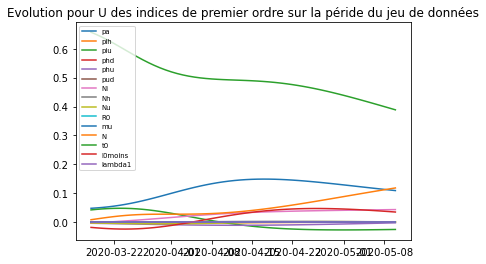

In [34]:
plt.plot(periode,pa,label='pa')
plt.plot(periode,pih,label='pih')
plt.plot(periode,piu,label='piu')
plt.plot(periode,phd,label='phd')
plt.plot(periode,phu,label='phu')
plt.plot(periode,pud,label='pud')
plt.plot(periode,Ni,label='Ni')
plt.plot(periode,Nh,label='Nh')
plt.plot(periode,Nu,label='Nu')
plt.plot(periode,R0,label='R0')
plt.plot(periode,mu,label='mu')
plt.plot(periode,N,label='N')
plt.plot(periode,t0,label='t0')
plt.plot(periode,I0moins,label='I0moins')
plt.plot(periode,lambda1,label='lambda1')
plt.title('Evolution pour U des indices de premier ordre sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

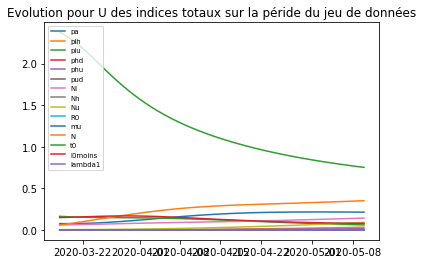

In [35]:
plt.plot(periode,pat,label='pa')
plt.plot(periode,piht,label='pih')
plt.plot(periode,piut,label='piu')
plt.plot(periode,phdt,label='phd')
plt.plot(periode,phut,label='phu')
plt.plot(periode,pudt,label='pud')
plt.plot(periode,Nit,label='Ni')
plt.plot(periode,Nht,label='Nh')
plt.plot(periode,Nut,label='Nu')
plt.plot(periode,R0t,label='R0')
plt.plot(periode,mut,label='mu')
plt.plot(periode,Nt,label='N')
plt.plot(periode,t0t,label='t0')
plt.plot(periode,I0moinst,label='I0moins')
plt.plot(periode,lambda1t,label='lambda1')
plt.title('Evolution pour U des indices totaux sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

In [36]:
pa =[]
pih =[]
piu =[]
phd =[]
phu =[]
pud =[]
Ni =[]
Nh =[]
Nu =[]
R0 =[]
mu =[]
N =[]
t0 =[]
I0moins =[]
lambda1 =[]
pat =[]
piht =[]
piut =[]
phdt =[]
phut =[]
pudt =[]
Nit =[]
Nht =[]
Nut =[]
R0t =[]
mut =[]
Nt =[]
t0t =[]
I0moinst =[]
lambda1t =[]
for i in range(len(D[0])):
    d = D[:,i]
    Si_D = sobol.analyze(problem,d)
    pa.append(Si_D['S1'][0])
    pih.append(Si_D['S1'][1])
    piu.append(Si_D['S1'][2])
    phd.append(Si_D['S1'][3])
    phu.append(Si_D['S1'][4])
    pud.append(Si_D['S1'][5])
    Ni.append(Si_D['S1'][6])
    Nh.append(Si_D['S1'][7])
    Nu.append(Si_D['S1'][8])
    R0.append(Si_D['S1'][9])
    mu.append(Si_D['S1'][10])
    N.append(Si_D['S1'][11])
    t0.append(Si_D['S1'][12])
    I0moins.append(Si_D['S1'][13])
    lambda1.append(Si_D['S1'][14])
    pat.append(Si_D['ST'][0])
    piht.append(Si_D['ST'][1])
    piut.append(Si_D['ST'][2])
    phdt.append(Si_D['ST'][3])
    phut.append(Si_D['ST'][4])
    pudt.append(Si_D['ST'][5])
    Nit.append(Si_D['ST'][6])
    Nht.append(Si_D['ST'][7])
    Nut.append(Si_D['ST'][8])
    R0t.append(Si_D['ST'][9])
    mut.append(Si_D['ST'][10])
    Nt.append(Si_D['ST'][11])
    t0t.append(Si_D['ST'][12])
    I0moinst.append(Si_D['ST'][13])
    lambda1t.append(Si_D['ST'][14])

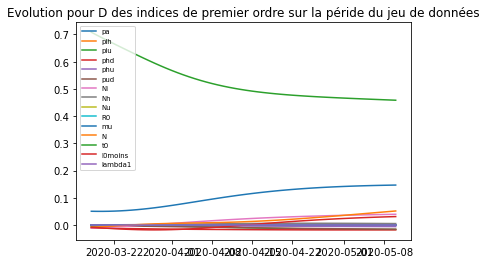

In [37]:
plt.plot(periode,pa,label='pa')
plt.plot(periode,pih,label='pih')
plt.plot(periode,piu,label='piu')
plt.plot(periode,phd,label='phd')
plt.plot(periode,phu,label='phu')
plt.plot(periode,pud,label='pud')
plt.plot(periode,Ni,label='Ni')
plt.plot(periode,Nh,label='Nh')
plt.plot(periode,Nu,label='Nu')
plt.plot(periode,R0,label='R0')
plt.plot(periode,mu,label='mu')
plt.plot(periode,N,label='N')
plt.plot(periode,t0,label='t0')
plt.plot(periode,I0moins,label='I0moins')
plt.plot(periode,lambda1,label='lambda1')
plt.title('Evolution pour D des indices de premier ordre sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

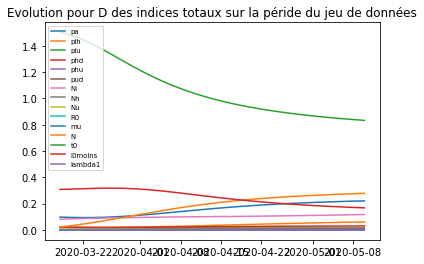

In [38]:
plt.plot(periode,pat,label='pa')
plt.plot(periode,piht,label='pih')
plt.plot(periode,piut,label='piu')
plt.plot(periode,phdt,label='phd')
plt.plot(periode,phut,label='phu')
plt.plot(periode,pudt,label='pud')
plt.plot(periode,Nit,label='Ni')
plt.plot(periode,Nht,label='Nh')
plt.plot(periode,Nut,label='Nu')
plt.plot(periode,R0t,label='R0')
plt.plot(periode,mut,label='mu')
plt.plot(periode,Nt,label='N')
plt.plot(periode,t0t,label='t0')
plt.plot(periode,I0moinst,label='I0moins')
plt.plot(periode,lambda1t,label='lambda1')
plt.title('Evolution pour D des indices totaux sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

In [39]:
pa =[]
pih =[]
piu =[]
phd =[]
phu =[]
pud =[]
Ni =[]
Nh =[]
Nu =[]
R0 =[]
mu =[]
N =[]
t0 =[]
I0moins =[]
lambda1 =[]
pat =[]
piht =[]
piut =[]
phdt =[]
phut =[]
pudt =[]
Nit =[]
Nht =[]
Nut =[]
R0t =[]
mut =[]
Nt =[]
t0t =[]
I0moinst =[]
lambda1t =[]
for i in range(len(RplusH[0])):
    r = RplusH[:,i]
    Si_R = sobol.analyze(problem,r)
    pa.append(Si_R['S1'][0])
    pih.append(Si_R['S1'][1])
    piu.append(Si_R['S1'][2])
    phd.append(Si_R['S1'][3])
    phu.append(Si_R['S1'][4])
    pud.append(Si_R['S1'][5])
    Ni.append(Si_R['S1'][6])
    Nh.append(Si_R['S1'][7])
    Nu.append(Si_R['S1'][8])
    R0.append(Si_R['S1'][9])
    mu.append(Si_R['S1'][10])
    N.append(Si_R['S1'][11])
    t0.append(Si_R['S1'][12])
    I0moins.append(Si_R['S1'][13])
    lambda1.append(Si_R['S1'][14])
    pat.append(Si_R['ST'][0])
    piht.append(Si_R['ST'][1])
    piut.append(Si_R['ST'][2])
    phdt.append(Si_R['ST'][3])
    phut.append(Si_R['ST'][4])
    pudt.append(Si_R['ST'][5])
    Nit.append(Si_R['ST'][6])
    Nht.append(Si_R['ST'][7])
    Nut.append(Si_R['ST'][8])
    R0t.append(Si_R['ST'][9])
    mut.append(Si_R['ST'][10])
    Nt.append(Si_R['ST'][11])
    t0t.append(Si_R['ST'][12])
    I0moinst.append(Si_R['ST'][13])
    lambda1t.append(Si_R['ST'][14])

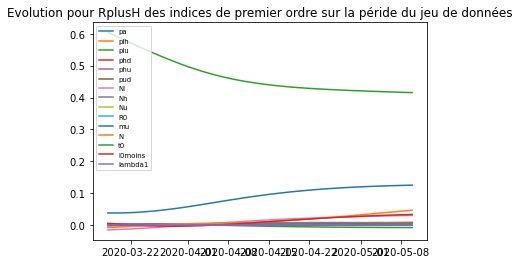

In [40]:
plt.plot(periode,pa,label='pa')
plt.plot(periode,pih,label='pih')
plt.plot(periode,piu,label='piu')
plt.plot(periode,phd,label='phd')
plt.plot(periode,phu,label='phu')
plt.plot(periode,pud,label='pud')
plt.plot(periode,Ni,label='Ni')
plt.plot(periode,Nh,label='Nh')
plt.plot(periode,Nu,label='Nu')
plt.plot(periode,R0,label='R0')
plt.plot(periode,mu,label='mu')
plt.plot(periode,N,label='N')
plt.plot(periode,t0,label='t0')
plt.plot(periode,I0moins,label='I0moins')
plt.plot(periode,lambda1,label='lambda1')
plt.title('Evolution pour RplusH des indices de premier ordre sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

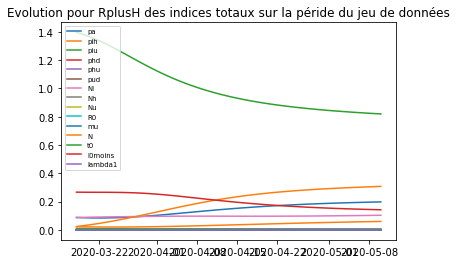

In [41]:
plt.plot(periode,pat,label='pa')
plt.plot(periode,piht,label='pih')
plt.plot(periode,piut,label='piu')
plt.plot(periode,phdt,label='phd')
plt.plot(periode,phut,label='phu')
plt.plot(periode,pudt,label='pud')
plt.plot(periode,Nit,label='Ni')
plt.plot(periode,Nht,label='Nh')
plt.plot(periode,Nut,label='Nu')
plt.plot(periode,R0t,label='R0')
plt.plot(periode,mut,label='mu')
plt.plot(periode,Nt,label='N')
plt.plot(periode,t0t,label='t0')
plt.plot(periode,I0moinst,label='I0moins')
plt.plot(periode,lambda1t,label='lambda1')
plt.title('Evolution pour RplusH des indices totaux sur la péride du jeu de données')
plt.legend(loc='upper left', fontsize='x-small')
plt.show()

#### Question 6: 

In [42]:
import pandas as pd
data = pd.read_csv('donnees-hospitalieres-covid19-18_03-11_05.csv',sep=';',encoding='unicode_escape')
df = data.copy()
df.drop(55,0,inplace=True)
plt.plot(df['Jour'],df['Somme de hosp'],label='hosp')
plt.plot(df['Jour'],df['Somme de rea'],label='rea')
plt.plot(df['Jour'],df['Somme de rad'],label='gueri apres hosp')
plt.plot(df['Jour'],df['Somme de dc'],label='dc')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'donnees-hospitalieres-covid19-18_03-11_05.csv'

In [ ]:
data = pd.read_csv('open_stats_coronavirus.csv',sep=';')
dfm = data.copy()
dfm.drop('code',1,inplace=True)
dfm.drop('nom',1,inplace=True)
dfm.drop('source',1,inplace=True)
dfm

In [ ]:
df['jour'] = dfm['date']
df.drop('Jour',1,inplace=True)
for i,x in enumerate(df['jour']):
     df['jour'][i] = np.datetime64(x).astype('float')
df['cas'] = dfm['cas']
for i in range(1,len(df['cas'])):
    df['cas'][len(df['cas'])-i] = df['cas'][len(df['cas'])-i] - df['cas'][len(df['cas'])-i-1]
df['cas'][0] = df['cas'][1]
df

In [ ]:
plt.plot(df['jour'],df['Somme de hosp'],label='hosp')
plt.plot(df['jour'],df['Somme de rea'],label='rea')
plt.plot(df['jour'],df['Somme de rad'],label='gueri apres hosp')
plt.plot(df['jour'],df['Somme de dc'],label='dc')
plt.plot(df['jour'],df['cas'],label='nouveau cas quotidien')
plt.legend()
plt.show()

Question 7)

In [ ]:
dfc = df.copy()
dfc['Somme de hosp'].astype('float')
dfc['Somme de rea'].astype('float')
dfc['Somme de rad'].astype('float')
dfc['Somme de dc'].astype('float')
dfc['cas'].astype('float')
dfc

In [ ]:
def Para_entree_vector() :
    pa = rd.random()*(0.9 - 0.4)+ 0.4
    pih = rd.random()*(0.2 - 0.05)+ 0.05
    piu = rd.random()*(0.04 - 0.01)+ 0.01
    phd = rd.random()*(0.2 - 0.1)+ 0.1
    phu = rd.random()*(0.2 - 0.1)+ 0.1
    pud = rd.random()*(0.4 - 0.2)+ 0.2
    Ni = rd.random()*(12 - 8)+ 8
    Nh = rd.random()*(25 - 15)+ 15
    Nu = rd.random()*(20 - 10)+ 10
    R0 = rd.random()*(3.4 - 2.9)+ 2.9
    mu = rd.random()*(0.08 - 0.01)+ 0.01
    N = (rd.random()*(np.datetime64('2020-03-15')-np.datetime64('2020-02-24'))+np.datetime64('2020-02-24')).astype('float')
    t0 = (rd.random()*(np.datetime64('2020-02-24')-np.datetime64('2020-01-25'))+np.datetime64('2020-01-25')).astype('float')
    I0moins = rd.random()*(25 - 15)+ 1
    lambda1 = rd.random()*(10**(-3)-10**(-4))+10**(-4)
    
    return np.array([pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1])

In [ ]:
x0 = Para_entree_vector()

In [ ]:
x0[12] =x0[12].astype('float')
x0[11] =x0[11].astype('float')
pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1 = x0[0],x0[1],x0[2],x0[3],x0[4],x0[5],x0[6],x0[7],x0[8],x0[9],x0[10],x0[11],x0[12],x0[13],x0[14]

In [ ]:
t0 = x0[12]
print(t0)
index = int(np.datetime64('2020-03-18').astype('float')-t0)
index

In [ ]:
def Para_systeme_vector(x):
    pa,pih,piu,phd,phu,pud,Ni,Nh,Nu,R0,mu,N,t0,I0moins,lambda1 = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14]
    gammaIR = (pa+(1-pa)*(1-pih-piu))/Ni
    gammaIH = (1-pa)*pih/Ni
    gammaIU = (1-pa)*piu/Ni
    gammaHD = phd/Nh
    gammaHU = phu/Nh
    gammaHR = (1-phd-phu)/Nh
    gammaUD = pud/Nu
    gammaUR = (1-pud)/Nu
    tau0 = R0*(lambda1+gammaIR+gammaIH+gammaIU)/S0
    return np.array([I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0])

In [ ]:
def Simulation_epidemie_vector(x):
    X = [[0 for i in range(10)]] #X représente l'ensemble des vecteurs qui regroupent les 10 compartiments du modèle épidémique
    I0moins,gammaIR,gammaIH,gammaIU,gammaHD,gammaHU,gammaHR,gammaUD,gammaUR,tau0 = x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]
    #On initialise notre modèle
    X[0][0] = S0 
    X[0][1] = I0moins

    #On utilise une première approche approximée à l'ordre 1 pour résoudre le système d'équation différentielle
    periode = np.arange(t0, np.datetime64('2020-08-01').astype('float'))
    for n in periode[:-1]:     
        Xnew = [0 for i in range(10)]
        Xold = X[-1]
        Xnew[0] = Xold[0] - tau(n)*Xold[0]*Xold[1]
        Xnew[1] = (1-lambda1)*Xold[1] + tau(n.astype('float'))*Xold[0]*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[1]
        Xnew[2] = Xold[2] + lambda1*Xold[1] - (gammaIR+gammaIH+gammaIU)*Xold[2]
        Xnew[3] = (1-lambda2)*Xold[3] + gammaIR*Xold[1]
        Xnew[4] = Xold[4] + gammaIR*Xold[2] +lambda2*Xold[3]
        Xnew[5] = (1-(gammaHR+gammaHD+gammaHU))*Xold[5] + gammaIH*(Xold[1]+Xold[2])
        Xnew[6] = (1-(gammaUR+gammaUD))*Xold[6] + gammaIU*(Xold[1]+Xold[2]) + gammaHU*Xold[5]
        Xnew[7] = Xold[7] + gammaHR*Xold[5] + gammaUR*Xold[6]
        Xnew[8] = Xold[8] + gammaUD*Xold[6] + gammaHD*Xold[5]
        Xnew[9] = (lambda1+gammaIH+gammaIU)*Xold[1]
        X.append(Xnew)
    return X,periode

In [ ]:
def Compartiments_epidemie_vector(X):
    S = np.array([x[0] for x in X[:]])
    Imoins = np.array([x[1] for x in X[:]])
    Iplus = np.array([x[2] for x in X[:]])
    Rmoins = np.array([x[3] for x in X[:]])
    RplusI = np.array([x[4] for x in X[:]])
    H = np.array([x[5] for x in X[:]])
    U = np.array([x[6] for x in X[:]])
    RplusH = np.array([x[7] for x in X[:]])
    D = np.array([x[8] for x in X[:]])
    DR = np.array([x[9] for x in X[:]])
    return S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR

In [ ]:
c = df['cas'].to_numpy()
c

In [ ]:
n = len(df['jour'])
n

In [ ]:
def tau(n):
    return tau0*np.exp(-mu*np.maximum((n-N),0))

In [ ]:
def eps(x):
    a , p = Simulation_epidemie_vector(Para_systeme_vector(x))
    S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR = Compartiments_epidemie_vector(a)
    DR = DR[index:index+n]
    H = H[index:index+n]
    U = U[index:index+n]
    D = D[index:index+n]
    R = RplusH[index:index+n]
    fdr = (DR-df['cas'])/np.sqrt(DR)
    fh = (H-df['Somme de hosp'].astype('float').to_numpy())/np.sqrt(H)
    fu = (U-df['Somme de rea'].astype('float').to_numpy())/np.sqrt(U)
    fd = (D-df['Somme de dc'].astype('float').to_numpy())/np.sqrt(D)
    fr = (R-df['Somme de rad'].astype('float').to_numpy())/np.sqrt(R)
    return np.sum(fdr**2+fh**2+fu**2+fd**2+fr**2)

In [ ]:
eps(x0)

In [ ]:
from scipy.optimize import minimize
bnds = ((0.4, 0.9), (0.05, 0.2),(0.01,0.04),(0.1, 0.2), (0.1, 0.2),(0.2,0.4),(8, 12), (15,25),(10,20),(2.9, 3.4), (0.01, 0.08),(np.datetime64('2020-02-24').astype('int'),np.datetime64('2020-03-15').astype('int')),(np.datetime64('2020-01-25').astype('int'),np.datetime64('2020-02-24').astype('int')), (1, 100),(10**(-4),10**(-3)))
x_star = minimize(eps,x0, bounds=bnds)

x_star

In [ ]:
xbest = x_star.__getitem__('x')
xbest

#Simulation épidemie
X,periode = Simulation_epidemie_vector(Para_systeme_vector(xbest))
S,Imoins,Iplus,Rmoins,RplusI,H,U,RplusH,D,DR=Compartiments_epidemie_vector(X)

#Représentation de la vague épidémique
plt.plot(periode,D,label="Individus décédés")
plt.plot(periode,H,label="Individus à l'hopital")
plt.plot(periode,U,label="Individus en soins intensifs")
plt.xlabel("Dates de la première vague de l'épidémie")
plt.ylabel("Nombre de patients")
plt.title("Evolution de l'épidémie")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fancybox=True, shadow=True)

#### Question 8

Pour obtenir les valeurs $\sigma^*$ qui maximisent la vraisemblance, on annule les dérivées partielles $\frac{\partial{\ln(p(data/x,\sigma))}}{\partial{\sigma_C}}$ , pour $C \in \{DR,H,U,D,R\}$.

Pour $C=DR$, $\frac{\partial{\ln(p(data/x,\sigma))}}{\partial{\sigma_{DR}}} = \frac{-n_{DR}}{\sigma_{DR}} + \overset{n_{DR}}{\underset{i=1}{\sum}}\frac{f_{DR}(x,s_i)^2}{\sigma_{DR}^3}$,
on en déduit alors ${\sigma^*_{DR}}^2=\sum_i{f_{DR}(x,s_i)^2/n_{DR}}$

Pour $C \in \{H,U,D,R\}$ on obtient par la même méthode ${\sigma^*_{C}}^2=\sum_i{f_{C}(x,t_i)^2/n_{C}}$

#### Question 9

Dans l'approche plug-in, on fixe les paramètres $\sigma$ aux valeurs $\sigma^*$ maximisant la vraisemblance et calculées précédemment. 
On applique alors le théorème de Bayes et on obtient une expression implicite de la loi a posteriori des paramètres: 

$\mathbb{P}(x/data)=\frac{\mathbb{P}(x,data)}{\mathbb{P}(data)} = \frac{\mathbb{P}(data/x,\sigma^*)\times \mathbb{P_0}(x)}{\mathbb{P}(data)}$, avec $\mathbb{P_0}$ loi a priori du paramètre $x \in \mathbb{R}^{15}$ et $\mathbb{P}(data)=\int_x{\mathbb{P}(data/x,\sigma^*)\times \mathbb{P_0}(x) \times dx}$, une constante de normalisation implicite.

Dans le cas full-bayésien, on suit la même méthode mais les $\sigma$ suivent une loi non-informative de Jeffreys, et on obtient le même type d'expression de la loi a posteriori.